<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Bridge_Cracks/Bridge_Cracks_EfficientNetB0_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ==============================================
# EfficientNetB0 for Bridge Cracks (Single Folder)
# ==============================================

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ----------------------------
# 2. Imports
# ----------------------------
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ----------------------------
# 3. Dataset Path
# ----------------------------
dataset_dir = '/content/drive/MyDrive/Bridge_Cracks'  # contains Positive & Negative subfolders

# ----------------------------
# 4. Detect Image Size Automatically
# ----------------------------
import cv2
sample_class = os.listdir(dataset_dir)[0]
sample_image_path = os.path.join(dataset_dir, sample_class, os.listdir(os.path.join(dataset_dir, sample_class))[0])
sample_image = cv2.imread(sample_image_path)
img_height, img_width = sample_image.shape[:2]
print(f"Detected image size: {img_height}x{img_width}")

# ----------------------------
# 5. Load Dataset with 80/20 Split
# ----------------------------
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ----------------------------
# 6. Data Augmentation
# ----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# ----------------------------
# 7. Build Model (Fine-tuning)
# ----------------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # fine-tune all layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ----------------------------
# 8. Train Model
# ----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detected image size: 200x200
Found 3822 files belonging to 2 classes.
Using 3058 files for training.
Found 3822 files belonging to 2 classes.
Using 764 files for validation.
Classes: ['Negative', 'Positive']


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 4,335,998 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 793ms/step - accuracy: 0.7542 - loss: 0.4720 - val_accuracy: 0.9738 - val_loss: 0.1427
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 305ms/step - accuracy: 0.9582 - loss: 0.1128 - val_accuracy: 0.9869 - val_loss: 0.0447
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 310ms/step - accuracy: 0.9805 - loss: 0.0617 - val_accuracy: 0.9882 - val_loss: 0.0372
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 340ms/step - accuracy: 0.9801 - loss: 0.0723 - val_accuracy: 0.9935 - val_loss: 0.0333
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 308ms/step - accuracy: 0.9805 - loss: 0.0613 - val_accuracy: 0.9895 - val_loss: 0.0347
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.9768 - loss: 0.0592 - val_accuracy: 0.9935 - val_loss: 0.0178
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.9919 - loss: 0.0289 - val_accuracy: 0.9921 - val_loss: 0.0260
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 312ms/step - accuracy: 0.9915 - loss: 0.0264 - val_acc

In [8]:
# ----------------------------
# Calculate metrics and display as DataFrame
# ----------------------------
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics_df(y_true, y_pred, dataset_name="Dataset"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    df = pd.DataFrame({
        "Dataset": [dataset_name],
        "Accuracy": [acc],
        "Precision": [prec],
        "Recall": [rec],
        "F1-score": [f1]
    })
    return df

# Create DataFrames for training and validation
df_train_metrics = metrics_df(y_true_train, y_pred_train, "Training")
df_val_metrics = metrics_df(y_true_val, y_pred_val, "Validation")

# Combine into one DataFrame
df_metrics = pd.concat([df_train_metrics, df_val_metrics], ignore_index=True)
df_metrics


,Dataset,Accuracy,Precision,Recall,F1-score
0,Training,0.996730,0.996729,0.996730,0.996729
1,Validation,0.992147,0.992186,0.992147,0.992158


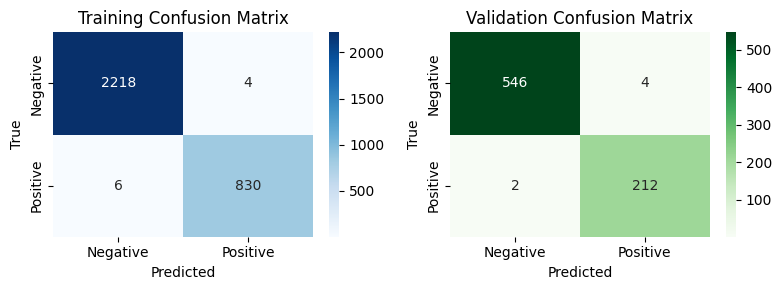

In [15]:
# Confusion matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_val = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices_train_val.png')
plt.show()


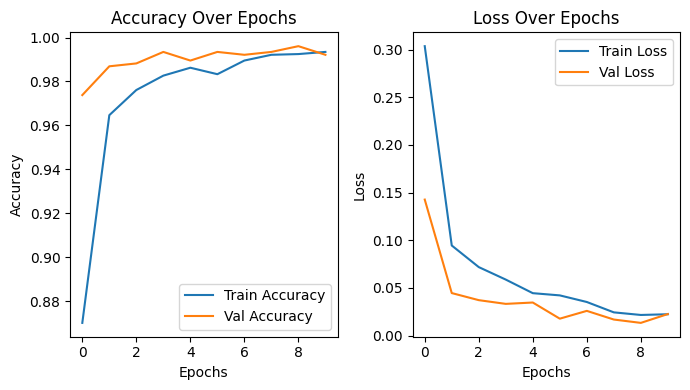

In [13]:
# ----------------------------
# 10. Accuracy & Loss Plots
# ----------------------------
plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('accuracy_loss.png')
plt.show()

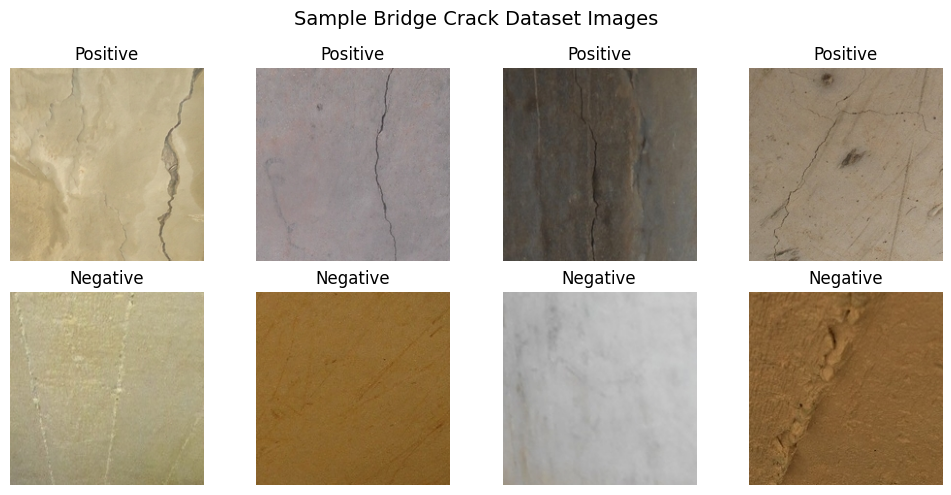

In [20]:
import matplotlib.pyplot as plt
import os
import cv2
import random

# Paths for Positive and Negative subfolders
positive_dir = os.path.join(dataset_dir, "Positive")
negative_dir = os.path.join(dataset_dir, "Negative")

# Pick 4 random samples from each class
positive_samples = random.sample(os.listdir(positive_dir), 4)
negative_samples = random.sample(os.listdir(negative_dir), 4)

# Plot figure
fig, axes = plt.subplots(2, 4, figsize=(10,5))

# First row: Positive cracks
for i, img_name in enumerate(positive_samples):
    img_path = os.path.join(positive_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Positive")
    axes[0, i].axis("off")

# Second row: Negative (no cracks)
for i, img_name in enumerate(negative_samples):
    img_path = os.path.join(negative_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Negative")
    axes[1, i].axis("off")

plt.suptitle("Sample Bridge Crack Dataset Images", fontsize=14)
plt.tight_layout()
plt.savefig("sample_bridge_crack_images.png")
plt.show()
